In [1]:
import os
from PIL import Image
import random
from pathlib import Path

dataDir = Path("/Z/cuhk_data/HPACG")
train_positive_dir = dataDir / "train/positive"
train_negative_dir = dataDir / "train/negative"

test_positive_dir = dataDir / "test/positive"
test_negative_dir = dataDir / "test/negative"

In [7]:
# Basic info
count_files = lambda dir: sum(1 for _ in os.listdir(dir))

Ntrain_positive = count_files(train_positive_dir)
Ntrain_negative = count_files(train_negative_dir)

Ntest_positive = count_files(test_positive_dir)
Ntest_negative = count_files(test_negative_dir)

Ndeleted = count_files(dataDir / "removed")

print("Number of files\n")

print(f"Train folder\nPositve: {Ntrain_positive}\nNegative: {Ntrain_negative}\n\nTest folder\nPositive: {Ntest_positive}\nNegative: {Ntest_negative}")
print(f"\n\nDeleted: {Ndeleted}")

Number of files

Train folder
Positve: 3016
Negative: 2078

Test folder
Positive: 1293
Negative: 894


Deleted: 4156


In [3]:
random.choice(os.listdir(train_positive_dir))

'23S002120-II.svs_41472_15360_0_512_512_1.png'

In [4]:
import torch, torchvision
import torch.nn as nn
from torchvision import transforms
from CHIEF.models.ctran import ctranspath
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from PIL import Image, ImageFile, PngImagePlugin
Image.MAX_IMAGE_PIXELS = None 
PngImagePlugin.MAX_TEXT_CHUNK = 100 * 1024 * 1024  # 100MB
PngImagePlugin.MAX_TEXT_MEMORY = 100 * 1024 * 1024 # 100MB

ImageFile.LOAD_TRUNCATED_IMAGES = True


mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trnsfrms_val = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std)
    ]
)

model = ctranspath()
model.head = nn.Identity()
td = torch.load(r'./CHIEF/model_weight/CHIEF_CTransPath.pth', weights_only=True)
model.load_state_dict(td['model'], strict=True)
model.eval()

SwinTransformer(
  (patch_embed): ConvStem(
    (proj): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True

In [7]:
next(model.parameters())[0].device

device(type='cpu')

In [ ]:
image = Image.open("./test_img.png").convert("RGB")
image = trnsfrms_val(image).unsqueeze(dim=0)
with torch.no_grad():
    patch_feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,768]
    # print(patch_feature_emb.size())

TypeError: forward() got an unexpected keyword argument 'output_attentions'

In [10]:
model

SwinTransformer(
  (patch_embed): ConvStem(
    (proj): Sequential(
      (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(24, 96, kernel_size=(1, 1), stride=(1, 1))
    )
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True

In [ ]:
from os.path import join as j_

train_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'train'), transform=trnsfrms_val)
test_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'test'), transform=trnsfrms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=16)

In [ ]:
from UNI.uni.downstream.eval_patch_features.logistic_regression import LogisticRegression
from UNI.uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from UNI.uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

In [51]:
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

100%|██████████| 858/858 [03:06<00:00,  4.60it/s]


In [57]:
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

In [71]:
from UNI.uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([8005, 768])
Linear Probe Evaluation: Test shape torch.Size([3432, 768])
Linear Probe Evaluation (Train Time): Best cost = 15.360
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([8005, 768])
(Before Training) Loss: 0.693
(After Training) Loss: 0.467
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3432, 768])
Linear Probe Evaluation: Time taken 0.13
Test lin_acc: 0.800
Test lin_bacc: 0.799
Test lin_kappa: 0.597
Test lin_weighted_f1: 0.800
Test lin_auroc: 0.891


True Positive Rate (Sensitivity,recall): [0.779]
False Positive Rate : [0.183]
Specificity : [0.817]
Balanced Accuracy : [0.798]
Precision: [0.790]


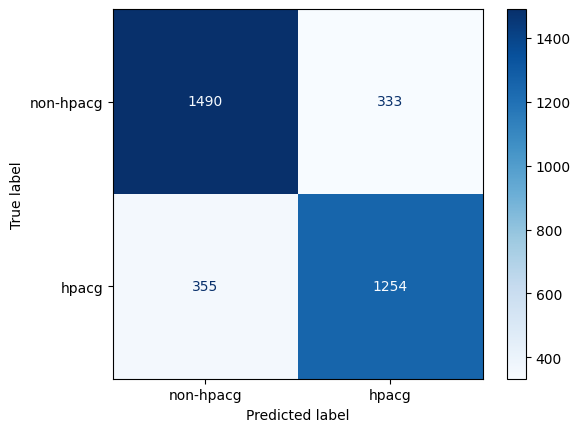

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_true = linprobe_dump['preds_all']
y_pred = linprobe_dump['targets_all']
cm = confusion_matrix(y_true, y_pred)

labels = ['non-hpacg', 'hpacg']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

TN, FP, FN, TP = confusion_matrix=cm.ravel()

tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
specificity = TN / (TN + FP) if (FP + TN) > 0 else 0
Balanced_Accuracy = (specificity + tpr) / 2
Precision = TP  / (TP + FP) if (TP + FP) > 0 else 0
Weight_F1 = ((Precision * tpr) / (Precision + tpr))*2

print(f"True Positive Rate (Sensitivity,recall): [{tpr:.3f}]")
print(f"False Positive Rate : [{fpr:.3f}]")
print(f"Specificity : [{specificity:.3f}]")
print(f"Balanced Accuracy : [{Balanced_Accuracy:.3f}]")
print(f"Precision: [{Precision:.3f}]")

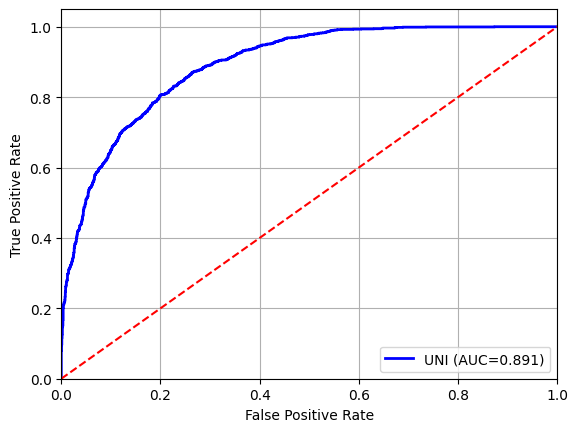

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

true_labels = linprobe_dump['targets_all']
pred_probs = linprobe_dump['probs_all']

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'UNI (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()